In [23]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime #for working with times objects
from datetime import timedelta #for working with times objects
from collections import Counter
import folium #map
import matplotlib.pyplot as plt #color and graph
import matplotlib.cm as cm #color
import math
import random
import glob
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import f_regression

In [24]:
data = pd.read_csv("predict_bike.csv", low_memory=False)

In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 686 entries, 0 to 685
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   end_station              686 non-null    int64  
 1   hour                     686 non-null    int64  
 2   avg_trip_count           686 non-null    float64
 3   idle_time                686 non-null    float64
 4   idle_bikes_count         686 non-null    int64  
 5   temperature              686 non-null    float64
 6   windspeed                686 non-null    float64
 7   bad_weather_condition    686 non-null    int64  
 8   month                    686 non-null    int64  
 9   season                   686 non-null    float64
 10  hour_sin                 686 non-null    float64
 11  hour_cos                 686 non-null    float64
 12  avg_duration_passholder  686 non-null    float64
 13  passholder_indego        686 non-null    int64  
 14  is_weekday               6

In [26]:
# Annahme: Ihr DataFrame heißt "data" und enthält Features und die Zielvariable "idle_time"
X = data.drop('idle_time', axis=1)  # Features
y = data['idle_time']  # Zielvariable


In [27]:
# Führen Sie den F-Test durch und erhalten Sie die F-Scores und p-Werte für jeden Feature
f_scores, p_values = f_regression(X, y)

# f_scores enthält die F-Scores für jedes Feature
# p_values enthält die p-Werte für jedes Feature

# Sie können die Ergebnisse in einem DataFrame speichern, um sie zu analysieren
f_test_results = pd.DataFrame({'Feature': X.columns, 'F-Score': f_scores, 'p-value': p_values})

print(f_test_results)


                    Feature     F-Score        p-value
0               end_station    3.536423   6.045944e-02
1                      hour    0.213801   6.439512e-01
2            avg_trip_count    1.678521   1.955582e-01
3          idle_bikes_count  715.064900  2.198033e-108
4               temperature   14.430532   1.583689e-04
5                 windspeed    1.422146   2.334640e-01
6     bad_weather_condition    0.027666   8.679448e-01
7                     month    0.571777   4.498139e-01
8                    season    0.236207   6.271149e-01
9                  hour_sin    0.110855   7.392748e-01
10                 hour_cos    0.363189   5.469401e-01
11  avg_duration_passholder    0.758549   3.840885e-01
12        passholder_indego    1.435611   2.312658e-01
13               is_weekday    0.129413   7.191525e-01
14                POI_Count    6.920916   8.711149e-03
15            summer_winter    9.421320   2.229616e-03


In [29]:
wissen: 
    über season gleich verteilt => season uninteressant
    selbe mit monat
    hour_sin & hour_cos ??
    avg_duration_passholder erstmal raus später mal reinnehmen
    

SyntaxError: invalid syntax (3844380050.py, line 1)

In [30]:
# Annahme: Ihr DataFrame heißt "data" und enthält Features und die Zielvariable "idle_time"
drop_column = []
X = data.drop(['idle_time'] + drop_column, axis=1)  # Features
y = data['idle_time']  # Zielvariable

# Aufteilung der Daten in Trainings- und Testsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

# Skalieren der Features (normalerweise empfehlenswert für SVR)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [31]:
param_grid = {
    'C': [0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0, ],  # Liste von C-Werten, die ausprobiert werden sollen
    'kernel': ['linear', 'rbf', "poly", "sigmoid"],  # Liste der Kernel-Typen, die ausprobiert werden sollen
    'epsilon': [0.1, 0.01, 0.001]  # Liste von Epsilon-Werten, die ausprobiert werden sollen
}


In [32]:
svr_model = SVR()
grid_search = GridSearchCV(estimator=svr_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train) 


GridSearchCV(cv=5, estimator=SVR(),
             param_grid={'C': [0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0],
                         'epsilon': [0.1, 0.01, 0.001],
                         'kernel': ['linear', 'rbf', 'poly', 'sigmoid']},
             scoring='neg_mean_squared_error')

In [33]:
print("Beste Hyperparameter: ", grid_search.best_params_)


Beste Hyperparameter:  {'C': 10000.0, 'epsilon': 0.1, 'kernel': 'linear'}


In [34]:
best_svr_model = grid_search.best_estimator_
y_pred = best_svr_model.predict(X_test_scaled) 
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE) mit den besten Hyperparametern: ", mse)
print("R-squared (R2) mit den besten Hyperparametern: ", r2)

df = pd.DataFrame({"Actual" : y_test, "Predicted" : y_pred})
df

Mean Squared Error (MSE) mit den besten Hyperparametern:  3940869.9383061123
R-squared (R2) mit den besten Hyperparametern:  0.7562729597270326


,Actual,Predicted
286,44.0,-172.201578
652,107.0,-127.623116
257,32.0,-188.360534
336,3700.0,1796.249233
318,97.0,1802.191557
...,...,...
209,1435.0,1395.573364
598,3702.0,1860.894388
66,921.0,881.128772
11,14079.0,4173.221436


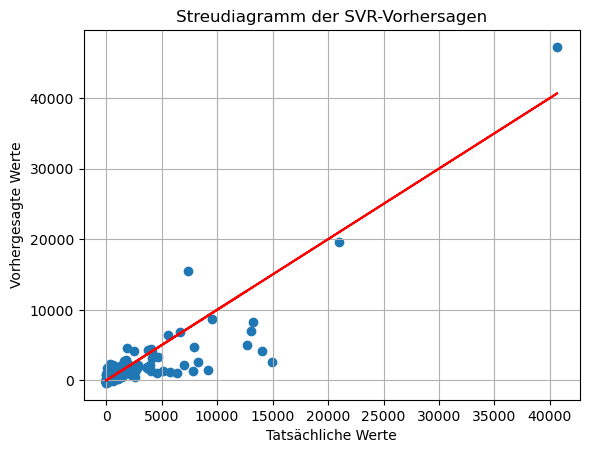

In [35]:


# Annahme: y_test enthält die tatsächlichen Werte, und y_pred enthält die vorhergesagten Werte
plt.scatter(y_test, y_pred)
plt.plot(y_test, y_test, c="r")
plt.xlabel('Tatsächliche Werte')
plt.ylabel('Vorhergesagte Werte')
plt.title('Streudiagramm der SVR-Vorhersagen')
plt.grid()
plt.show()


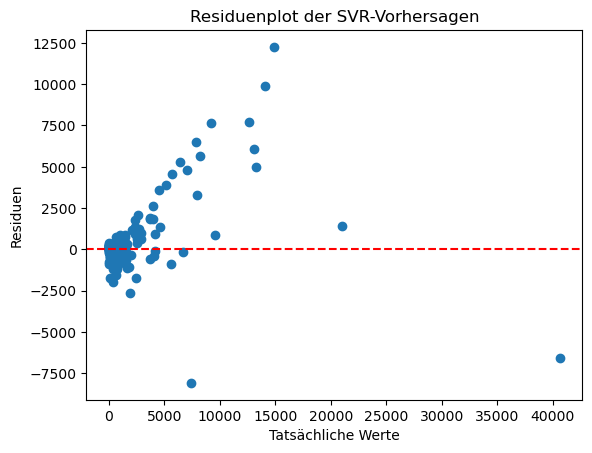

In [36]:
residuen = y_test - y_pred
plt.scatter(y_test, residuen)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Tatsächliche Werte')
plt.ylabel('Residuen')
plt.title('Residuenplot der SVR-Vorhersagen')
plt.show()


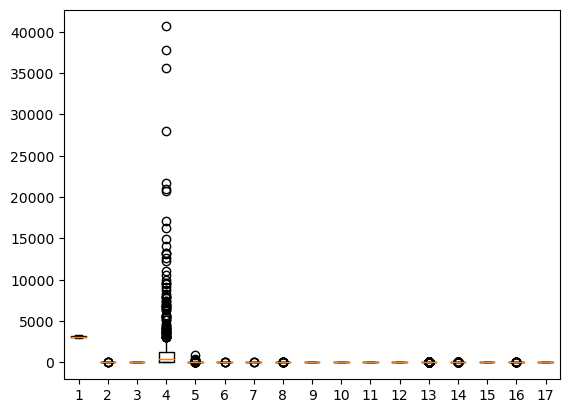

In [37]:
plt.boxplot(data)
plt.show()

In [38]:
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Entfernen von Ausreißern
filtered_data = data[~((data < lower_bound) | (data > upper_bound)).any(axis=1)]


In [39]:
# Annahme: Ihr DataFrame heißt "filtered_data" und enthält Features und die Zielvariable "idle_time"
drop_column = []
X = filtered_data.drop(["idle_time"] + drop_column, axis=1)  # Features
y = filtered_data['idle_time']  # Zielvariable

# Aufteilung der Daten in Trainings- und Testsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Skalieren der Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Erstellen des SVR-Modells mit einem bestimmten Kernel (z. B. 'rbf' für einen radialen Basisfunktionen-Kernel)
svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)

# Trainieren des Modells
svr_model.fit(X_train_scaled, y_train)

# Vorhersage auf dem Testset durchführen
y_pred = svr_model.predict(X_test_scaled)

# Bewertung des Modells mit verschiedenen Metriken
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r2)


Mean Squared Error (MSE): 367773.7379048218
R-squared (R2): -0.02702489239036554


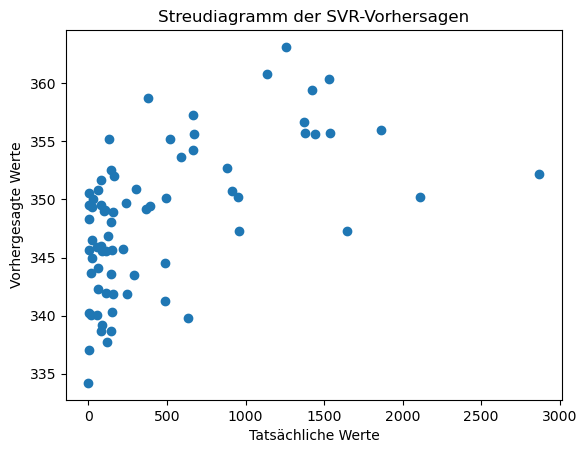

In [40]:
# Annahme: y_test enthält die tatsächlichen Werte, und y_pred enthält die vorhergesagten Werte
plt.scatter(y_test, y_pred)
plt.xlabel('Tatsächliche Werte')
plt.ylabel('Vorhergesagte Werte')
plt.title('Streudiagramm der SVR-Vorhersagen')
plt.show()


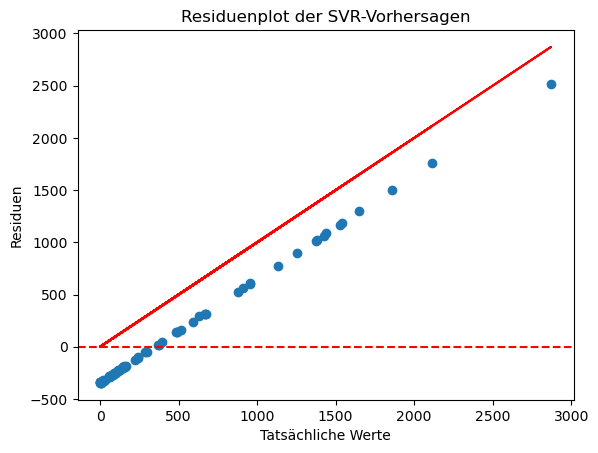

In [41]:
residuen = y_test - y_pred
plt.scatter(y_test, residuen)
plt.plot(y_test, y_test, c="r")
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Tatsächliche Werte')
plt.ylabel('Residuen')
plt.title('Residuenplot der SVR-Vorhersagen')
plt.show()


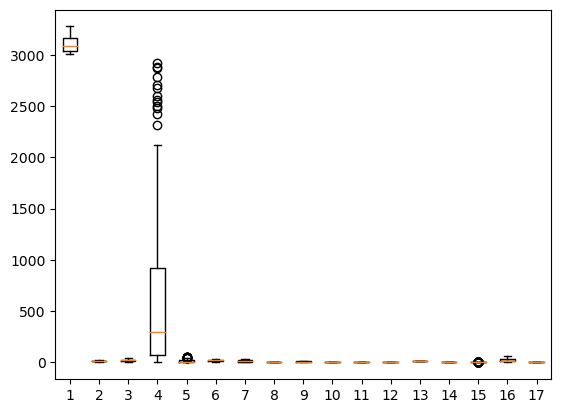

In [42]:
plt.boxplot(filtered_data)
plt.show()
